# Long-range CNOT gate teleportation using dynamic circuits

## Step 1: Map the problem to circuits and operators

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
## For classical logic on mid-circuit bit strings
from qiskit.circuit.classical import expr



def get_dynamic_CNOT_circuit(num_qubit):
    """
    (1) 1D chain of nearest neighbors
    (2) 0th qubit is in the control, and the last qubit (num_qubit-1) is the target
    (3) The control qubit starts in the + state
    """
    ## ancilla bits: extra bits used to perform irreversable logical operations,
    ## in this case, all the qubits in between the first and last qubits
    num_ancilla = num_qubit - 2
    num_ancilla_pair = int(num_ancilla / 2)
    
    
    qr = QuantumRegister(num_qubit)
    ## Want classical register to store bits to compute parity of bit string in conditional X gate.
    cr1 = ClassicalRegister(num_ancilla_pair, name="cr1")
    ## Want classical register to store the bit string used to compute the parity of the conditional Z gate.
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name = "cr2")
    ## Classical register to store results of measurements of control and target qubits
    cr3 = ClassicalRegister(2, name="cr3")
    
    ## BUILDING THE CIRCUIT: Initialize the control qubit (assumed to begin in plus state)
    qc = QuantumCircuit(qr, cr1, cr2, cr3)
    ## Apply hadamard gate to ensure that the control gate begins in a plus state
    qc.h(0)
    qc.barrier()
    
    
    ## Entangle the control qubit and the first ancilla qubit (in index 1)
    qc.cx(0, 1) ## (CNOT gate)
    
    ## Create Bell pairs on ancilla qubits
    for i in range(num_ancilla_pair):
        ## Apply hadamard gate to alternating ancilla qubits
        qc.h(2+2*i)
        ## Entangle them using CNOT gate
        qc.cx(2+2*i, 2+2*i+1)
        
    
    ## Prepare Bell pairs on staggered ancilla and data qubits
    for i in range(num_ancilla_pair + 1):
        qc.cx(1+2*i, 1+2*i + 1)
    for i in range(1, num_ancilla_pair+2):
        qc.h(2*i - 1)
        
    ## Measurement on alternating ancilla qubits starting with the first one
    ## Keep track of the parity (symmetry of system) for eventual conditional Z gate
    """ MAIN IDEA: Does the next classical bit change the parity?? """
    for i in range(1, num_ancilla_pair + 2):
        qc.measure(2*i - 1, cr2[i-1])
        ## Start to compute parity as you go through measurements
        if i == 1:
            ## Converts scalar value into logical value that qiskit can understand
            parity_control = expr.lift(cr2[i-1])
        else:
            """ 
            If they are the exact same value -> parity is the same -> parity control should be zero
            If they are different values -> parity has changed -> change parity control to one.
            """
            ### Implement such logic using bit xor logic.
            parity_control = expr.bit_xor(cr2[i-1], parity_control)
    
    # Measurement on staggered alternating ancilla qubits starting with the second one
    # Keep track of the parity of eventual conditional X gate
    for i in range(num_ancilla_pair):
        qc.measure(2*i + 2, cr1[i])
        if(i == 0):
            parity_target = expr.lift(cr1[i])
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target)
    
    
    ## Decide whether to do conditional z gate or x gate given the parity that is passed in
    with qc.if_test(parity_control):
        ## Control qubit (apply zero gate)
        qc.z(0)
    
    with qc.if_test(parity_target):
        ## Always know that the target qubit is the very last one
        qc.x(-1)
    ## Final measurements on the control and target qubits
    qc.measure(0, cr3[0])
    qc.measure(-1, cr3[1])
    
    return qc
        

Run simulation against paper

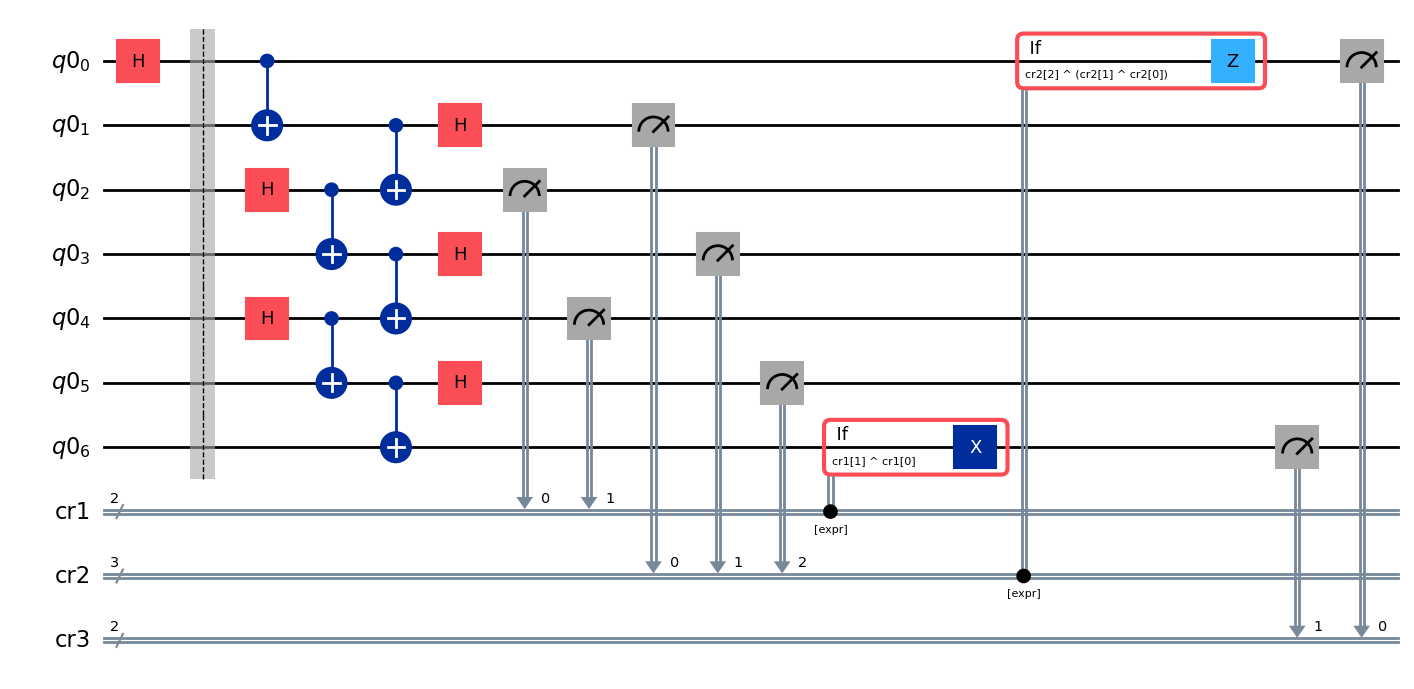

In [2]:
qc = get_dynamic_CNOT_circuit(num_qubit=7)
qc.draw(output='mpl')

# Check limitation of our system

In [18]:
max_num_qubit = 41
qc_list = []
num_qubit_list = list(range(7, max_num_qubit + 1, 2))
for num_qubit in num_qubit_list:
    ## Develops a list of long-range cnot gate teleportation from 7, 9, 11, ..., to 41 qubits
    qc_list.append(get_dynamic_CNOT_circuit(num_qubit))

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token = "ba406da5a32420f54b944858918925b8c7fcb24504eafb6aaf108a0817886ddf4bddad473d6062ca62d574ddb76c66ca9203118147efce07e34e4cd594f810ef")

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token="ba406da5a32420f54b944858918925b8c7fcb24504eafb6aaf108a0817886ddf4bddad473d6062ca62d574ddb76c66ca9203118147efce07e34e4cd594f810ef")

In [21]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="ba406da5a32420f54b944858918925b8c7fcb24504eafb6aaf108a0817886ddf4bddad473d6062ca62d574ddb76c66ca9203118147efce07e34e4cd594f810ef", overwrite=True)

## Step 2: Optimize the problem for quantum execution

In [22]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

# Step 3: Execute the circuit 

In [30]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id())

csh54a9p1vzg0089rr9g


## Step 4: Post-processing (and plotting)

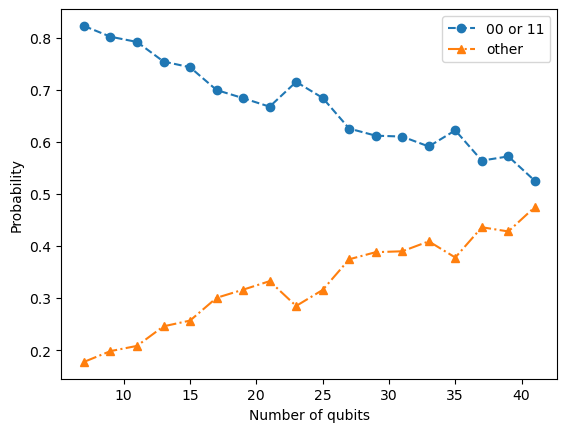

In [31]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = "csh54a9p1vzg0089rr9g"
service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

list_Bell = []
list_other = []
for i in range(0, len(qc_list)):
    data = result[i].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots

    prob_Bell = (counts['00'] + counts['11']) / total_counts

    list_Bell.append(prob_Bell)
    list_other.append(1-prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label='other')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()